In [15]:
from os.path import dirname, join, basename, isfile
from tqdm import tqdm

from models import SyncNet_color as SyncNet
import audio

import torch
from torch import nn
from torch import optim
import torch.backends.cudnn as cudnn
from torch.utils import data as data_utils
import numpy as np

from glob import glob

import os, random, cv2, argparse
from hparams import hparams, get_image_list

###################
import sklearn
from sklearn.model_selection import train_test_split
from hparams import hparams as hp

%matplotlib inline
import matplotlib.pyplot as plt

## Define paramaters

In [2]:
parser = argparse.ArgumentParser(description='Code to train the expert lip-sync discriminator')

parser.add_argument("--data_root", help="Root folder of the preprocessed LRS2 dataset", required=True)
parser.add_argument('--checkpoint_dir', help='Save checkpoints to this directory', required=True, type=str)
parser.add_argument('--checkpoint_path', help='Resumed from this checkpoint', default=None, type=str)

data_root = "C:\\Users\\ioann\\Desktop\\projects\\Github\\Wav2Lip\\data\\lrs2_preprocessed"
checkpoint_dir = "C:\\Users\\ioann\\Desktop\\projects\\Github\\Wav2Lip\\checkpoints\\syncnet"
# checkpoint_path = None

# Parse the arguments? with the values
args = parser.parse_args(args=["--data_root", data_root, 
                               "--checkpoint_dir", checkpoint_dir])

In [3]:
global_step = 0
global_epoch = 0
use_cuda = torch.cuda.is_available()
print('use_cuda: {}'.format(use_cuda))

syncnet_T = 5 # 
syncnet_mel_step_size = 16 # 

use_cuda: True


## Define the Dataset

In [4]:
class Dataset(object):
    def __init__(self, split):
        self.all_videos = get_image_list(args.data_root, split)

    def get_frame_id(self, frame):
        return int(basename(frame).split('.')[0])

    def get_window(self, start_frame):
        start_id = self.get_frame_id(start_frame)
        vidname = dirname(start_frame)

        window_fnames = []
        for frame_id in range(start_id, start_id + syncnet_T):
            frame = join(vidname, '{}.jpg'.format(frame_id))
            if not isfile(frame):
                return None
            window_fnames.append(frame)
        return window_fnames

    def crop_audio_window(self, spec, start_frame):
        # num_frames = (T x hop_size * fps) / sample_rate
        start_frame_num = self.get_frame_id(start_frame)
        start_idx = int(80. * (start_frame_num / float(hparams.fps)))

        end_idx = start_idx + syncnet_mel_step_size

        return spec[start_idx : end_idx, :]


    def __len__(self):
        return len(self.all_videos)

    def __getitem__(self, idx):
        while 1:
            idx = random.randint(0, len(self.all_videos) - 1)
            vidname = self.all_videos[idx]

            img_names = list(glob(join(vidname, '*.jpg')))
            if len(img_names) <= 3 * syncnet_T:
                continue
            img_name = random.choice(img_names)
            wrong_img_name = random.choice(img_names)
            while wrong_img_name == img_name:
                wrong_img_name = random.choice(img_names)

            if random.choice([True, False]):
                y = torch.ones(1).float()
                chosen = img_name
            else:
                y = torch.zeros(1).float()
                chosen = wrong_img_name

            window_fnames = self.get_window(chosen)
            if window_fnames is None:
                continue

            window = []
            all_read = True
            for fname in window_fnames:
                img = cv2.imread(fname)
                if img is None:
                    all_read = False
                    break
                try:
                    img = cv2.resize(img, (hparams.img_size, hparams.img_size))
                except Exception as e:
                    all_read = False
                    break

                window.append(img)

            if not all_read: continue

            try:
                wavpath = join(vidname, "audio.wav")
                wav = audio.load_wav(wavpath, hparams.sample_rate)

                orig_mel = audio.melspectrogram(wav).T
            except Exception as e:
                continue

            mel = self.crop_audio_window(orig_mel.copy(), img_name)

            if (mel.shape[0] != syncnet_mel_step_size):
                continue

            # H x W x 3 * T
            x = np.concatenate(window, axis=2) / 255.
            x = x.transpose(2, 0, 1)
            x = x[:, x.shape[1]//2:]

            x = torch.FloatTensor(x)
            mel = torch.FloatTensor(mel.T).unsqueeze(0)

            return x, mel, y

## Functions

In [5]:
logloss = nn.BCELoss()

def cosine_loss(a, v, y):
    d = nn.functional.cosine_similarity(a, v)
    loss = logloss(d.unsqueeze(1), y)

    return loss

In [6]:
def eval_model(test_data_loader, global_step, device, model, checkpoint_dir):
    eval_steps = 1400
    print('Evaluating for {} steps'.format(eval_steps))
    losses = []
    while 1:
        for step, (x, mel, y) in enumerate(test_data_loader):

            model.eval()

            # Transform data to CUDA device
            x = x.to(device)

            mel = mel.to(device)

            a, v = model(mel, x)
            y = y.to(device)

            loss = cosine_loss(a, v, y)
            losses.append(loss.item())

            if step > eval_steps: break

        averaged_loss = sum(losses) / len(losses)
        print(averaged_loss)

        return

In [7]:
def save_checkpoint(model, optimizer, step, checkpoint_dir, epoch):

    checkpoint_path = join(
        checkpoint_dir, "checkpoint_step{:09d}.pth".format(global_step))
    optimizer_state = optimizer.state_dict() if hparams.save_optimizer_state else None
    torch.save({
        "state_dict": model.state_dict(),
        "optimizer": optimizer_state,
        "global_step": step,
        "global_epoch": epoch,
    }, checkpoint_path)
    print("Saved checkpoint:", checkpoint_path)

In [8]:
def _load(checkpoint_path):
    if use_cuda:
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path,
                                map_location=lambda storage, loc: storage)
    return checkpoint

In [9]:
def load_checkpoint(path, model, optimizer, reset_optimizer=False):
    global global_step
    global global_epoch

    print("Load checkpoint from: {}".format(path))
    checkpoint = _load(path)
    model.load_state_dict(checkpoint["state_dict"])
    if not reset_optimizer:
        optimizer_state = checkpoint["optimizer"]
        if optimizer_state is not None:
            print("Load optimizer state from {}".format(path))
            optimizer.load_state_dict(checkpoint["optimizer"])
    global_step = checkpoint["global_step"]
    global_epoch = checkpoint["global_epoch"]

    return model

In [10]:
def train(device, model, train_data_loader, test_data_loader, optimizer, checkpoint_dir=None, checkpoint_interval=None, nepochs=None):
    global global_step, global_epoch
    resumed_step = global_step
    while global_epoch < nepochs:
        running_loss = 0.
        prog_bar = tqdm(enumerate(train_data_loader))
        for step, (x, mel, y) in prog_bar:
            model.train()
            optimizer.zero_grad()

            # Transform data to CUDA device
            x = x.to(device)

            mel = mel.to(device)

            a, v = model(mel, x) # pass mel spectrogram and half-frames
            y = y.to(device)

            loss = cosine_loss(a, v, y)
            loss.backward()
            optimizer.step()

            global_step += 1
            cur_session_steps = global_step - resumed_step
            running_loss += loss.item()

            if global_step == 1 or global_step % checkpoint_interval == 0:
                save_checkpoint(
                    model, optimizer, global_step, checkpoint_dir, global_epoch)

            if global_step % hparams.syncnet_eval_interval == 0:
                with torch.no_grad():
                    eval_model(test_data_loader, global_step, device, model, checkpoint_dir)

            prog_bar.set_description('Loss: {}'.format(running_loss / (step + 1)))

        global_epoch += 1

## Run the code

In [11]:
train_li, val_li = train_test_split(["\\".join(i.split("\\")[-2:]) for i in glob(os.path.join(args.data_root, "*/*"))], train_size=0.8, shuffle=True, random_state=1)

with open('C:/Users/ioann/Desktop/projects/Github/Wav2Lip/filelists/train.txt', 'w') as f:
    for line in train_li:
        f.write(f"{line}\n")

with open('C:/Users/ioann/Desktop/projects/Github/Wav2Lip/filelists/val.txt', 'w') as f:
    for line in val_li:
        f.write(f"{line}\n")

In [12]:
# Dataset and Dataloader setup
train_dataset = Dataset('train')
test_dataset = Dataset('val')

train_data_loader = data_utils.DataLoader(
    train_dataset, batch_size=hp.syncnet_batch_size, shuffle=True,
    num_workers=hp.num_workers)

test_data_loader = data_utils.DataLoader(
    test_dataset, batch_size=hp.syncnet_batch_size,
    num_workers=0)

In [13]:
x, mel, y = train_dataset.__getitem__(1)

c:\Users\ioann\Desktop\projects\Github\Wav2Lip\audio.py:100: FutureWarning: Pass sr=16000, n_fft=800 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.filters.mel(hp.sample_rate, hp.n_fft, n_mels=hp.num_mels,


In [25]:
mel.shape

torch.Size([1, 80, 16])

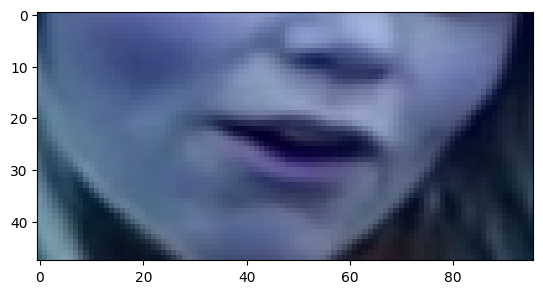

In [24]:
plt.imshow(x[:3].detach().cpu().permute(1,2,0).numpy())
plt.show()

In [13]:
device = torch.device("cuda" if use_cuda else "cpu")

# Model
model = SyncNet().to(device)
print('total trainable params {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad],
                        lr=hparams.syncnet_lr)

if args.checkpoint_path is not None:
    load_checkpoint(args.checkpoint_path, model, optimizer, reset_optimizer=False)


total trainable params 16435072


In [ ]:
train(device, 
      model, 
      train_data_loader, 
      test_data_loader, 
      optimizer,
      args.checkpoint_dir,
      hp.syncnet_checkpoint_interval,
      hp.nepochs)

0it [00:00, ?it/s]c:\Users\ioann\Desktop\projects\Github\Wav2Lip\audio.py:100: FutureWarning: Pass sr=16000, n_fft=800 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.filters.mel(hp.sample_rate, hp.n_fft, n_mels=hp.num_mels,
Loss: 0.6945393681526184: : 1it [00:04,  4.84s/it]

Saved checkpoint: C:\Users\ioann\Desktop\projects\Github\Wav2Lip\checkpoints\checkpoint_step000000001.pth
